# tSNE on Amazon Reviews Dataset

In [3]:
#NOTE: Due to very large runtime, we have taken 4k positive and 4k negative reviews

In [4]:
# We will import the required packages for 

import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer


In [5]:
# At this stage we will be importing the required sqlite dataset

con = sqlite3.connect('database.sqlite')

'''
Our objective is to check whether the data is linearly seperable for positive and negative reviews.

The dataset originally consists of reviews from 1 to 5. We will consider reviews which are rated as 4 and 5 to be positive, reviews 
which are rated 1 and 2 to be negative. As, we cannot draw any conclusions from review which is rated 3 star we will eliminate
all the reviews rated 3 star.

'''

# Filtering out the data w/o the 3 star reviews.

filtered_data = pd.read_sql_query("""SELECT * FROM Reviews WHERE Score != 3""", con) 


In [6]:
# Checking whether the data has been filtered properly

filtered_data['Score'].unique()

# We can see that there is no 3 star review in the data

array([5, 1, 4, 2], dtype=int64)

In [7]:
# As we have eliminated the data with 3 start reviews, we will label the remaining data(4 and 5 scores) as positive and negative(1 and 2 scores).

# Creating a function to label the data
def partition(x):
    if x < 3:
        return 'negative'
    return 'positive'


# Applying the labels to the data

actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative

In [8]:
# Checking the first few rows of the data

filtered_data.head(10)

# We can see that the score has been changed to positive and negative instead of 5,4,1,2

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,positive,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,negative,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,positive,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,negative,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,positive,1350777600,Great taffy,Great taffy at a great price. There was a wid...
5,6,B006K2ZZ7K,ADT0SRK1MGOEU,Twoapennything,0,0,positive,1342051200,Nice Taffy,I got a wild hair for taffy and ordered this f...
6,7,B006K2ZZ7K,A1SP2KVKFXXRU1,David C. Sullivan,0,0,positive,1340150400,Great! Just as good as the expensive brands!,This saltwater taffy had great flavors and was...
7,8,B006K2ZZ7K,A3JRGQVEQN31IQ,Pamela G. Williams,0,0,positive,1336003200,"Wonderful, tasty taffy",This taffy is so good. It is very soft and ch...
8,9,B000E7L2R4,A1MZYO9TZK0BBI,R. James,1,1,positive,1322006400,Yay Barley,Right now I'm mostly just sprouting this so my...
9,10,B00171APVA,A21BT40VZCCYT4,Carol A. Reed,0,0,positive,1351209600,Healthy Dog Food,This is a very healthy dog food. Good for thei...


In [9]:
# Let us look at the shape of the data

filtered_data.shape

(525814, 10)

In [10]:
# First we will sort the data according to the timestamp in ascending order

sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [11]:
# Dropping any duplicates if they are present in the data

final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

(364173, 10)

In [12]:
# Eliminating the rows where helpfulness numerator is greator than the helfulness denominator

final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

In [13]:
# We will need only the review and the score column for the further processing, therefore we will only select the reqd columns

final_data = final[['Text','Score']]

In [14]:
# Checking the shape of the data

final_data.shape

(364171, 2)

In [15]:
# CHecking the first few rows of the data

final_data.shape

(364171, 2)

In [16]:
# Because of memory concerns we will select a sample of data and then perform the further processing

# Extracting only the positive reviews from 'final_data' dataframe

reviews_positive = final_data.loc[final_data['Score'] == 'positive']

In [17]:
# Checking the dimension of positive reviews
reviews_positive.shape


(307061, 2)

In [18]:
# Checking the first few rows to ensure we have the right data
reviews_positive.head(15)

,Text,Score
138706,this witty little book makes my son laugh at l...,positive
138688,"I grew up reading these Sendak books, and watc...",positive
138689,This is a fun way for children to learn their ...,positive
138690,This is a great little book to read aloud- it ...,positive
138691,This is a book of poetry about the months of t...,positive
138693,"A charming, rhyming book that describes the ci...",positive
138694,I set aside at least an hour each day to read ...,positive
138695,I remembered this book from my childhood and g...,positive
138696,It's a great book with adorable illustrations....,positive
138697,This book is a family favorite and was read to...,positive


In [19]:
'''
If we directly use the reviews_positive dataframe to sample the data, we get an 'unhashable slice' error. We need to extract the
dataframe values in an array  and then take the sample.
'''
# Assigning the values of the 'reviews_positive' data to X

X=reviews_positive.iloc[:,:].values

In [20]:
# Randomly selecting 2000 reviews of the given positive reviews

# Importing the random library
import random

n = 307061
m = 4000
p = m/n

sampled_positive = [];

for i in range(0,n):
    if random.random() <= p:
        sampled_positive.append(X[i,:])

In [2]:
print(sampled_positive)

In [22]:
# Converting the array to a dataframe

reviews_positive_final = pd.DataFrame(sampled_positive)

In [23]:
# Checking out the shape of the data
reviews_positive_final.shape

# We approximately have around 2000 columns which is what we wanted

(3999, 2)

In [24]:
# Checking out first few rows of the data

reviews_positive_final.head(15)

,0,1
0,My Westie loves these things! She loves anyth...,positive
1,"I THOUGHT THIS MOVIE WAS SO FUNNY, MICHAEL KEA...",positive
2,"It is strong and heavy duty, but reasonably pr...",positive
3,The most effective way to get rid of pocket go...,positive
4,"After reading some of the reviews, it seems li...",positive
5,I've just installed the third unit in our gara...,positive
6,I have two dogs and the flies are always aroun...,positive
7,I am glad that Amazon has a record of my order...,positive
8,Very good little set of colors. Very vibrant c...,positive
9,I bought one of these wine savers for my husba...,positive


In [25]:
# Following the same procedure for the negative reviews, here we will demonstrate the 'unhashable slice' error we get

# Extracting the negative reviews from the 'final_data' dataframe

reviews_negative = final_data.loc[final_data['Score'] == 'negative']

In [26]:
# Checking the shape of the data

reviews_negative.shape

(57110, 2)

In [27]:
# Checking the first few rows of the 'reviews_negative' dataframe

reviews_negative.head(15)

,Text,Score
138708,This is one of the best children's books ever ...,negative
138679,I give five stars to the Maurice Sendak story....,negative
22620,My dogs loves this chicken but its a product f...,negative
157869,I received all containers previously opened - ...,negative
157873,Same price as Dr. Foster & Smith.,negative
157870,"okay, it's freeze-dried liver cube-lets. my c...",negative
157871,I selected this company over the other even th...,negative
70666,What a horrible product. First of all the item...,negative
70661,I don't know how this product performs with bi...,negative
70663,We had a problem with a lot of fruit flies in ...,negative


In [27]:
# Taking a random sample of 2000 reviews from the dataframe

n = 57110
m = 2000
p = m/n

sampled_negative = [];

for i in range(0,n):
    if random.random() <= p:
        sampled_negative.append(reviews_negative[i,:])

TypeError: unhashable type: 'slice'

In [28]:
'''
We can see that we are getting an ' unhashable type : 'slice' ' error 

Thus, we will extract the dataframe values and further process the data
'''

X1 = reviews_negative.iloc[:,:].values

In [29]:
# Randomly selecting 4000 reviews of the given positive reviews

# Importing the random library
#import random

n = 57110
m = 4000
p = m/n

sampled_negative = [];

for i in range(0,n):
    if random.random() <= p:
        sampled_negative.append(X1[i,:])

In [3]:
# Checking if the data has been extracted in the 'sampled_negative' array

print(sampled_negative)

# We can see that the values have been extracted

In [32]:
# Converting the 'sampled_negative' dataset to a dataframe

reviews_negative_final = pd.DataFrame(sampled_negative)

In [33]:
# Checking the dimensions of the 'reviews_negative_final' dataframe

reviews_negative_final.shape

# We approximately have 2000 rows for the data

(3979, 2)

In [34]:
# Checking the first few rows of the dataset

reviews_negative_final.head(15)

# We can see that the dataframe has all the negative reviews

,0,1
0,I love this movie and I bought it on VHS a lon...,negative
1,Come on now. how can you make a 20th annivers...,negative
2,I bought six. Totally ineffective. Don't was...,negative
3,This is a poor excuse for a gopher trap. I hav...,negative
4,I bought 5 of these traps hoping to rid myself...,negative
5,"This device may work, but I have spent hours t...",negative
6,Terrible product! After 3 days of messing with...,negative
7,"This trap does the job, but nearly as well as ...",negative
8,"It didn't work for me...at all, and I have a s...",negative
9,You are better off buying dish soap a plate an...,negative


In [35]:
# Combining the two dataframes 'reviews_positive_final' and 'reviews_negative_final' into a single dataframe called 'reviews_final'

frames = [reviews_positive_final,reviews_negative_final]

reviews_final = pd.concat(frames)


In [36]:
#  Checking the dimension of the 'reviews_final' dataframe

reviews_final.shape

# We have a total of approximately 4000 reviews of which approximately 50% are positive and 50% negative.

(7978, 2)

In [37]:
# Checking the first few rows of the dataset

reviews_final.head(15)

,0,1
0,My Westie loves these things! She loves anyth...,positive
1,"I THOUGHT THIS MOVIE WAS SO FUNNY, MICHAEL KEA...",positive
2,"It is strong and heavy duty, but reasonably pr...",positive
3,The most effective way to get rid of pocket go...,positive
4,"After reading some of the reviews, it seems li...",positive
5,I've just installed the third unit in our gara...,positive
6,I have two dogs and the flies are always aroun...,positive
7,I am glad that Amazon has a record of my order...,positive
8,Very good little set of colors. Very vibrant c...,positive
9,I bought one of these wine savers for my husba...,positive


In [38]:
# We can see that the column names are missing for the dataframe
# Assigning the columns names 'Text' and 'Score' to the dataframe

reviews_final.columns = ['Text','Score']

In [39]:
# Checking whether the columns have been renamed

reviews_final.head(5)

# We can see that the names have been assigned to the columns

,Text,Score
0,My Westie loves these things! She loves anyth...,positive
1,"I THOUGHT THIS MOVIE WAS SO FUNNY, MICHAEL KEA...",positive
2,"It is strong and heavy duty, but reasonably pr...",positive
3,The most effective way to get rid of pocket go...,positive
4,"After reading some of the reviews, it seems li...",positive


In [40]:
# We can see that there are unknown elements like html tags in the data. We need to remove those

# find sentences containing HTML tags

import re

i=0;
for sent in reviews_final['Text'].values:
    if (len(re.findall('<.*?>', sent))):
        print(i)
        print(sent)
        break;
    i += 1;    


# We can see that we have sentences having html tags, removing the tags

5
I've just installed the third unit in our garage or outdoors on a tree branch.  In each case, after a few hours, the trap is surrounded by a swarm of flies practically going frantic to get inside.  They are ordinary house flies.  The numbers are shocking - they must be coming in from all over the county.<br /><br />The plastic bottle, screw-on lid, and little roof are quite rugged and would probably last indefinitely.  The unit comes with a length of wire that works nicely for hanging it from a ceiling fixture or small tree branch.<br /><br />The bait is a powder that you mix with water.  The smell is quite foul, rather like - well, you know what flies enjoy sitting on most.  It's definitely for outdoor use, although with ventilation you might place it in the garage or shed.<br /><br />My experience indicates it is wise to empty the bottle before it fills up completely with dead flies, living flies, and maggots.  This will be a disgusting task and the stink will be formidable - not s

In [41]:
'''
Now that we have a dataframe of both positive and negative reviews we will perform the data cleaning steps on the text data.
For that we will import some packages for stopwords removal, word stemmatization and cleaning html and punctuation marks.
'''
import re
from nltk.corpus import stopwords

nltk.download('stopwords')

stop = set(stopwords.words('english')) #set of stopwords
sno = nltk.stem.SnowballStemmer('english') #initialising the snowball stemmer

def cleanhtml(sentence): #function to clean the word of any html-tags
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, ' ', sentence)
    return cleantext
def cleanpunc(sentence): #function to clean the word of any punctuation or special characters
    cleaned = re.sub(r'[?|!|\'|"|#]',r'',sentence)
    cleaned = re.sub(r'[.|,|)|(|\|/]',r' ',cleaned)
    return  cleaned

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\kulkarni\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [42]:
#Code for implementing step-by-step the checks mentioned in the pre-processing phase
# this code takes a while to run as it needs to run on 500k sentences.
i=0
str1=' '
final_string=[]
all_positive_words=[] # store words from +ve reviews here
all_negative_words=[] # store words from -ve reviews here.
s=''
for sent in reviews_final['Text'].values:
    filtered_sentence=[]
    #print(sent);
    sent=cleanhtml(sent) # remove HTMl tags
    for w in sent.split():
        for cleaned_words in cleanpunc(w).split():
            if((cleaned_words.isalpha()) & (len(cleaned_words)>2)):    
                if(cleaned_words.lower() not in stop):
                    s=(sno.stem(cleaned_words.lower())).encode('utf8')
                    filtered_sentence.append(s)
                    if (final['Score'].values)[i] == 'positive': 
                        all_positive_words.append(s) #list of all words used to describe positive reviews
                    if(final['Score'].values)[i] == 'negative':
                        all_negative_words.append(s) #list of all words used to describe negative reviews reviews
                else:
                    continue
            else:
                continue 
    #print(filtered_sentence)
    str1 = b" ".join(filtered_sentence) #final string of cleaned words
    #print("***********************************************************************")
    
    final_string.append(str1)
    i+=1

In [43]:
# Assigning the 'final_string' array to the 'reviews_final' dataframe

reviews_final['Cleaned_Text'] = final_string

In [44]:
# Checking the first few rows of the dataset

reviews_final.head()

,Text,Score,Cleaned_Text
0,My Westie loves these things! She loves anyth...,positive,b'westi love thing love anyth liver one best e...
1,"I THOUGHT THIS MOVIE WAS SO FUNNY, MICHAEL KEA...",positive,b'thought movi funni michael keaton beetlejuic...
2,"It is strong and heavy duty, but reasonably pr...",positive,b'strong heavi duti reason price howev yet cau...
3,The most effective way to get rid of pocket go...,positive,b'effect way get rid pocket gopher ive tri thi...
4,"After reading some of the reviews, it seems li...",positive,b'read review seem like lot peopl success trap...


# BoW

# Creating our first BoW model

In [46]:

# While creating the BoW model we will be using the 'Cleaned_Text' column from the dataset.

#BoW
count_vect = CountVectorizer() #in scikit-learn
final_counts = count_vect.fit_transform(reviews_final['Cleaned_Text'].values).todense()

In [47]:

# Checking the type of 'final_counts' data
type(final_counts)

# We can see that the data is in a matrix form

numpy.matrixlib.defmatrix.matrix

# Creating a 'tsne' model using 'BoW' representation of our text data

In [48]:
from sklearn.manifold import TSNE

model_bow1 = TSNE(n_components=2, random_state=0)
# configuring the parameteres
# the number of components = 2
# default perplexity = 30
# default learning rate = 200
# default Maximum number of iterations for the optimization = 1000

tsne_data_bow1 = model_bow1.fit_transform(final_counts)


In [49]:
# creating a new data frame which help us in ploting the result data
tsne_data_bow1 = np.vstack((tsne_data_bow1.T, reviews_final['Score'])).T
tsne_df_bow1 = pd.DataFrame(data=tsne_data_bow1, columns=("Dim_1", "Dim_2", "label"))

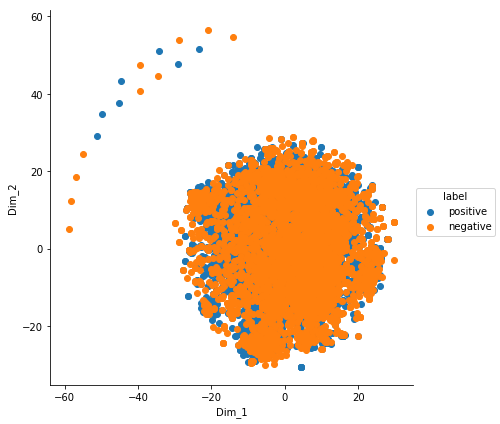

In [50]:
import seaborn as sn

# Ploting the result of tsne
sn.FacetGrid(tsne_df_bow1, hue="label", size=6).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
plt.show()

In [ ]:
'''The above figure is a 'tsne' representation by using Bow as vectorizer for the given reviews data.'''

# Creating the 'tsne' model by changing the perplexity(50)

In [51]:

#from sklearn.manifold import TSNE

model_bow2 = TSNE(n_components=2, random_state=0, perplexity= 50)
# configuring the parameteres
# the number of components = 2
# perplexity = 50
# default learning rate = 200
# default Maximum number of iterations for the optimization = 1000

tsne_data_bow2 = model_bow2.fit_transform(final_counts)


In [52]:
# creating a new data frame which help us in ploting the result data
tsne_data_bow2 = np.vstack((tsne_data_bow2.T, reviews_final['Score'])).T
tsne_df_bow2 = pd.DataFrame(data=tsne_data_bow2, columns=("Dim_1", "Dim_2", "label"))

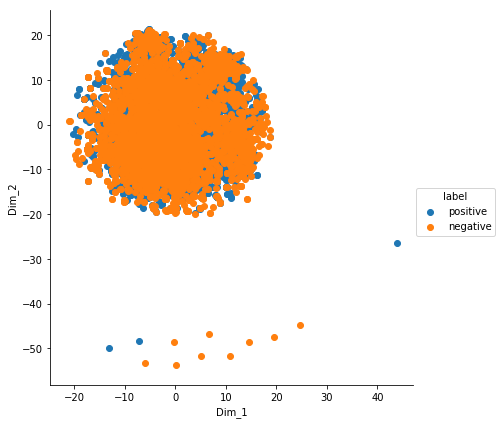

In [54]:
import seaborn as sn

# Ploting the result of tsne
sn.FacetGrid(tsne_df_bow2, hue="label", size=6).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
plt.show()

In [ ]:
'''The above figure is a 'tsne' representation with perplexity as 50 by using Bow as vectorizer for the given reviews data.'''

# Creating the 'tsne' model by changing the perplexity(40) and the number of iterations(2000)

In [56]:
from sklearn.manifold import TSNE

model_bow3 = TSNE(n_components=2, random_state=0, perplexity= 40, n_iter= 2000)
# configuring the parameteres
# the number of components = 2
# perplexity = 40
# default learning rate = 200
# Maximum number of iterations for the optimization = 2000

tsne_data_bow3 = model_bow3.fit_transform(final_counts)



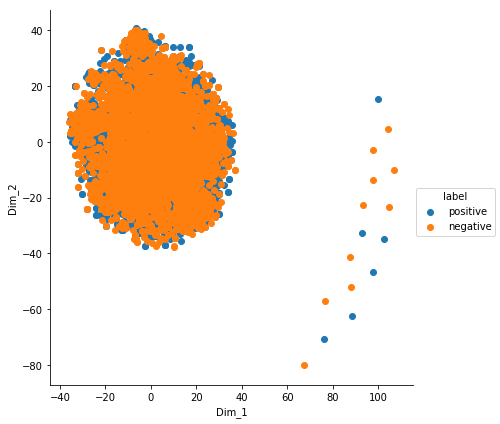

In [57]:
# creating a new data frame which help us in ploting the result data
tsne_data_bow3 = np.vstack((tsne_data_bow3.T, reviews_final['Score'])).T
tsne_df_bow3 = pd.DataFrame(data=tsne_data_bow3, columns=("Dim_1", "Dim_2", "label"))


import seaborn as sn

# Ploting the result of tsne
sn.FacetGrid(tsne_df_bow3, hue="label", size=6).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
plt.show()

In [ ]:
'''The above figure is a 'tsne' representation with perplexity as 40 and n_iter as 2000 by using 
Bow as vectorizer for the given reviews data.'''

# For our BoW representation of data, we will use ngrams as 1 and 2

In [58]:
#BoW
count_vect1 = CountVectorizer(ngram_range=(1,2)) #selecting the ngrams using ngram range
final_counts = count_vect1.fit_transform(reviews_final['Cleaned_Text'].values).todense()

# We can see that we are getting a memory error, we will avoid using ngrams for now.

MemoryError: 

# Tf-Idf

# We will be using the 'tf-idf' representation of our text data to create our tsne models using the 'Cleaned_Text' column of our data

In [45]:
tf_idf_vect = TfidfVectorizer()
final_tf_idf = tf_idf_vect.fit_transform(reviews_final['Cleaned_Text'].values).todense()

In [46]:
type(final_tf_idf)

numpy.matrixlib.defmatrix.matrix

# Creating the 'tsne' model using default parameters

In [47]:
# Creating the tsne model using the default parameters

from sklearn.manifold import TSNE
model_tfidf_first = TSNE(n_components=2, random_state=0)
# configuring the parameteres
# the number of components = 2
# default perplexity = 30
# default learning rate = 200
# default Maximum number of iterations for the optimization = 1000

tsne_data_tfidf_first = model_tfidf_first.fit_transform(final_tf_idf)

In [50]:
# creating a new data frame which help us in plotting the result data
#tsne_data_tfidf_first = np.vstack((tsne_data_tfidf_first.T, reviews_final['Score'])).T
tsne_df_tfidf_first = pd.DataFrame(data=tsne_data_tfidf_first, columns=("Dim_1", "Dim_2", "label"))

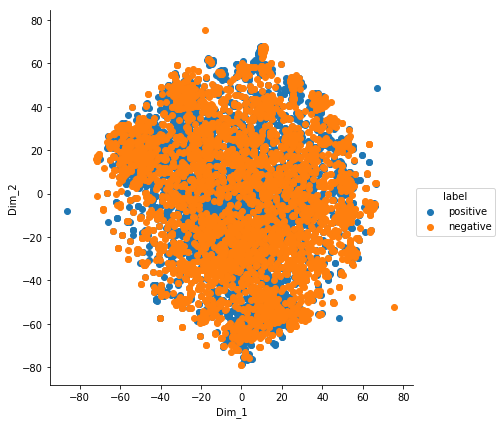

In [52]:
import seaborn as sn

# Ploting the result of tsne
sn.FacetGrid(tsne_df_tfidf_first, hue="label", size=6).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
plt.show()

In [ ]:
'''The above figure is a 'tsne' representation by using 
tfidf as vectorizer for the given reviews data.'''

# Creating the 'tsne' model by changing the perplexity(40) and the number of iterations(2000)

In [71]:
model_tfidf2 = TSNE(n_components=2, random_state=0, perplexity= 40, n_iter= 2000)
# configuring the parameteres
# the number of components = 2
# default perplexity = 40
# default learning rate = 200
# Maximum number of iterations for the optimization = 2000

tsne_data_tfidf2 = model_tfidf2.fit_transform(final_tf_idf)

In [77]:
tsne_data_tfidf2

array([[26.103574752807617, -3.358886480331421, 'positive'],
       [-1.4032038450241089, -17.588502883911133, 'positive'],
       [17.066646575927734, -57.80200958251953, 'positive'],
       ...,
       [0.036678850650787354, 56.06151580810547, 'negative'],
       [30.070690155029297, -15.60444164276123, 'negative'],
       [-12.23441219329834, -51.0308837890625, 'negative']], dtype=object)

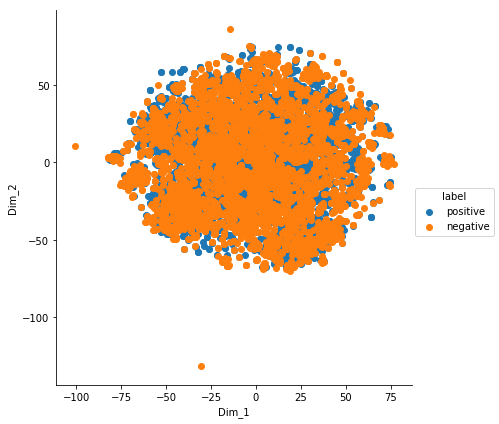

In [78]:
# creating a new data frame which help us in ploting the result data
#tsne_data_tfidf2 = np.vstack((tsne_data_tfidf2.T, reviews_final['Score'])).T
#tsne_df_tfidf2 = pd.DataFrame(data=tsne_data_tfidf2, columns=("Dim_1", "Dim_2", "label"))


#import seaborn as sn

#Ploting the result of tsne
sn.FacetGrid(tsne_df_tfidf2, hue="label", size=6).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
plt.show()

In [ ]:
'''The above figure is a 'tsne' representation with perplexity as 40 and n_iter as 2000 by using 
tfidf as vectorizer for the given reviews data.'''

# Creating the 'tsne' model by changing the perplexity(50) and the number of iterations(2000)

In [79]:
model_tfidf3 = TSNE(n_components=2, random_state=0, perplexity= 50, n_iter= 2000)
# configuring the parameteres
# the number of components = 2
# perplexity = 30
# default learning rate = 200
# Maximum number of iterations for the optimization = 2000

tsne_data_tfidf3 = model_tfidf3.fit_transform(final_tf_idf)

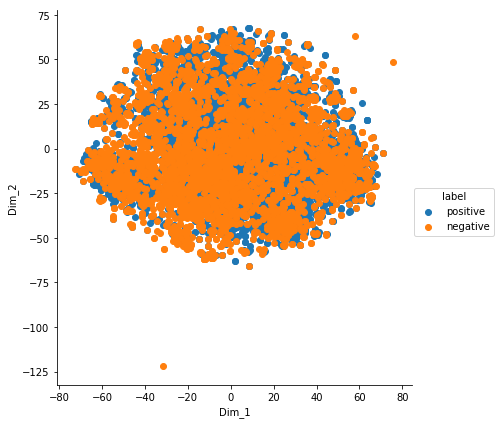

In [82]:
# creating a new data frame which help us in ploting the result data
#tsne_data_tfidf3 = np.vstack((tsne_data_tfidf3.T, reviews_final['Score'])).T
#tsne_df_tfidf3 = pd.DataFrame(data=tsne_data_tfidf3, columns=("Dim_1", "Dim_2", "label"))


#import seaborn as sn

# Ploting the result of tsne
sn.FacetGrid(tsne_df_tfidf3, hue="label", size=6).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
plt.show()

In [ ]:
'''The above figure is a 'tsne' representation with perplexity as 50 and n_iter as 2000 by using 
tfidf as vectorizer for the given reviews data.'''

# We will use Word2Vec representation to create the 'tsne' models

In [83]:
# Importing the required models for the project

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

C:\Users\kulkarni\Anaconda3\lib\site-packages\gensim\utils.py:1197: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [85]:
import gensim
i=0
list_of_sent=[]
for sent in reviews_final['Text'].values:
    filtered_sentence=[]
    sent=cleanhtml(sent)
    for w in sent.split():
        for cleaned_words in cleanpunc(w).split():
            if(cleaned_words.isalpha()):    
                filtered_sentence.append(cleaned_words.lower())
            else:
                continue 
    list_of_sent.append(filtered_sentence)
    

# Creating the Word2Vec model

In [86]:
w2v_model=gensim.models.Word2Vec(list_of_sent,min_count=5,size=50, workers=3)

In [87]:
words = list(w2v_model.wv.vocab)
print(len(words))

5775


# Creating AvgW2Vec representation of the text data 

In [88]:
# average Word2Vec
# compute average word2vec for each review.
sent_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sent in list_of_sent: # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        try:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
        except:
            pass
    sent_vec /= cnt_words
    sent_vectors.append(sent_vec)
print(len(sent_vectors))
print(len(sent_vectors[0]))

8040
50


# Creating a 'tsne' model using the AvgW2Vec representation of the text data 

In [89]:
#from sklearn.manifold import TSNE

model_avgw2vec1 = TSNE(n_components=2, random_state=0)
# configuring the parameteres
# the number of components = 2
# default perplexity = 30
# default learning rate = 200
# default Maximum number of iterations for the optimization = 1000

tsne_data_avgw2vec1 = model_avgw2vec1.fit_transform(sent_vectors)

In [91]:
# creating a new data frame which help us in ploting the result data
#tsne_data_avgw2vec1 = np.vstack((tsne_data_avgw2vec1.T, reviews_final['Score'])).T
tsne_df_avgw2vec1 = pd.DataFrame(data=tsne_data_avgw2vec1, columns=("Dim_1", "Dim_2", "label"))

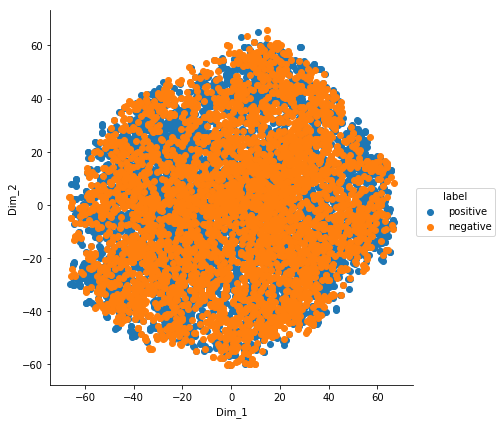

In [93]:
#import seaborn as sn

#Ploting the result of tsne
sn.FacetGrid(tsne_df_avgw2vec1, hue="label", size=6).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
plt.show()

In [ ]:
'''The above figure is a 'tsne' representation with  
AvgW2Vec as vectorizer for the given reviews data.'''

# Creating a 'tsne' model using the AvgW2Vec representation of the text data by changing the perplexity(40) and number of iterations(2000)

In [94]:
model_avgw2vec2 = TSNE(n_components=2, random_state=0, perplexity = 40, n_iter = 2000)
# configuring the parameteres
# the number of components = 2
# perplexity = 40
# default learning rate = 200
# default Maximum number of iterations for the optimization = 2000

tsne_data_avgw2vec2 = model_avgw2vec2.fit_transform(sent_vectors)

In [96]:
# creating a new data frame which help us in ploting the result data
#tsne_data_avgw2vec2 = np.vstack((tsne_data_avgw2vec2.T, reviews_final['Score'])).T
tsne_df_avgw2vec2 = pd.DataFrame(data=tsne_data_avgw2vec2, columns=("Dim_1", "Dim_2", "label"))

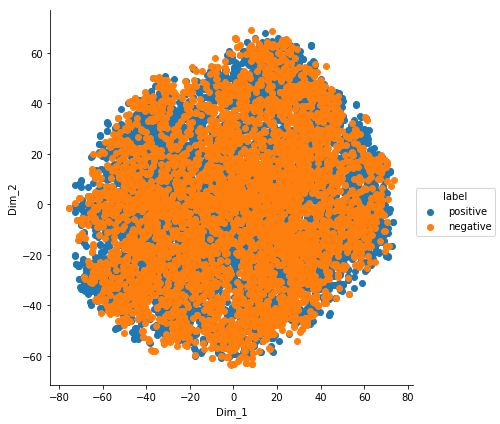

In [97]:
#import seaborn as sn

#Ploting the result of tsne
sn.FacetGrid(tsne_df_avgw2vec2, hue="label", size=6).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
plt.show()

In [ ]:
'''The above figure is a 'tsne' representation with perplexity as 40 and n_iter as 2000 by using 
tfidf as vectorizer for the given reviews data.'''

# Creating a 'tsne' model using the AvgW2Vec representation of the text data by changing the perplexity(50) and number of iterations(2000)

In [101]:
model_avgw2vec3 = TSNE(n_components=2, random_state=0, perplexity = 50,n_iter = 2000)
# configuring the parameteres
# the number of components = 2
# perplexity = 50
# default learning rate = 200
# Maximum number of iterations for the optimization = 2000

tsne_data_avgw2vec3 = model_avgw2vec3.fit_transform(sent_vectors)

In [103]:
# creating a new data frame which help us in ploting the result data
tsne_data_avgw2vec3 = np.vstack((tsne_data_avgw2vec3.T, reviews_final['Score'])).T
tsne_df_avgw2vec3 = pd.DataFrame(data=tsne_data_avgw2vec3, columns=("Dim_1", "Dim_2", "label"))

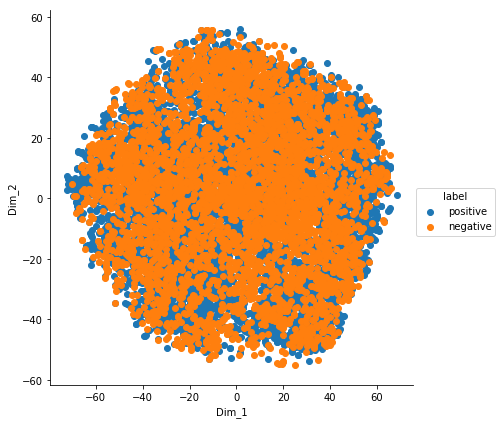

In [104]:
#import seaborn as sn

#Ploting the result of tsne
sn.FacetGrid(tsne_df_avgw2vec3, hue="label", size=6).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
plt.show()

In [ ]:
'''The above figure is a 'tsne' representation with perplexity as 50 and n_iter as 2000 by using 
'AvgW2Vec' as vectorizer for the given reviews data.'''

# Creating TF-IDF Weighted Word2Vec representation of the data

In [105]:
# TF-IDF weighted Word2Vec
tfidf_feat = tf_idf_vect.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in list_of_sent: # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        try:
            vec = w2v_model.wv[word]
            # obtain the tf_idfidf of a word in a sentence/review
            tf_idf = final_tf_idf[row, tfidf_feat.index(word)]
            #tfidf = final_tf_idf[row, tfidf_feat.index(word)]
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
        except:
            pass
    sent_vec /= weight_sum
    tfidf_sent_vectors.append(sent_vec)
    row += 1

C:\Users\kulkarni\Anaconda3\lib\site-packages\ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in true_divide


# Creating a 'tsne' model using the Tf-Idf weighted W2Vec representation of the text data 

In [106]:
model_tfidfweighted1 = TSNE(n_components=2, random_state=0)
# configuring the parameteres
# the number of components = 2
# default perplexity = 30
# default learning rate = 200
# default Maximum number of iterations for the optimization = 1000

tsne_data_tfidfweighted1 = model_tfidfweighted1.fit_transform(tfidf_sent_vectors)

ValueError: Input contains NaN, infinity or a value too large for dtype('float32').

In [ ]:
# We can see that we are getting a a value error for the above code.

In [107]:
# Checking for any 'NaN' values in the data

np.isnan(tfidf_sent_vectors).any()

# We can see that there are na values in the data

True

In [110]:
# We will replace all the 'Nan' values w/ mean of the respective columns


from sklearn.preprocessing import Imputer
imp = Imputer(missing_values='NaN', strategy='mean', axis=0)
data_tfidf = imp.fit_transform(tfidf_sent_vectors) # Assigning the imputed matrix w/o Nan values to data variable


In [111]:
# Checking the type of 'data_tfidf' 

type(data_tfidf)

# It is an array

numpy.ndarray

In [112]:
# Checking if our imputation has succeded

np.isnan(data_tfidf).any()

# We can see that there are no na values any more.

False

# Creating a 'tsne' model using Tf-Idf weighted W2Vec representation of the text data

In [114]:
tsne_data_tfidfweighted1 = model_tfidfweighted1.fit_transform(data_tfidf)

In [116]:
# creating a new data frame which help us in ploting the result data
#tsne_data_tfidfweighted1 = np.vstack((tsne_data_tfidfweighted1.T, reviews_final['Score'])).T
tsne_df_tfidfweighted1 = pd.DataFrame(data=tsne_data_tfidfweighted1, columns=("Dim_1", "Dim_2", "label"))


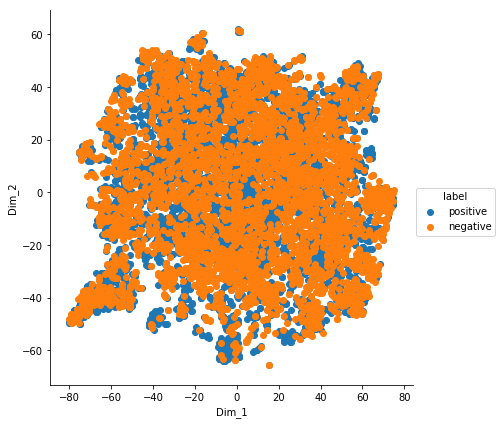

In [118]:
# PLotting the results 

sn.FacetGrid(tsne_df_tfidfweighted1, hue="label", size=6).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
plt.show()

In [ ]:
'''The above figure is a 'tsne' representation with 'TfIdf weighted W2Vec' as vectorizer for the given reviews data.'''

# Creating a 'tsne' model using the AvgW2Vec representation of the text data by changing the perplexity(40) and number of iterations(2000)

In [120]:
model_tfidfweighted2 = TSNE(n_components=2, random_state=0, perplexity = 40, n_iter = 2000)
# configuring the parameteres
# the number of components = 2
# perplexity = 40
# default learning rate = 200
# Maximum number of iterations for the optimization = 2000

tsne_data_tfidfweighted2 = model_tfidfweighted2.fit_transform(data_tfidf)

In [121]:
# creating a new data frame which help us in ploting the result data
tsne_data_tfidfweighted2 = np.vstack((tsne_data_tfidfweighted2.T, reviews_final['Score'])).T
tsne_df_tfidfweighted2 = pd.DataFrame(data=tsne_data_tfidfweighted2, columns=("Dim_1", "Dim_2", "label"))


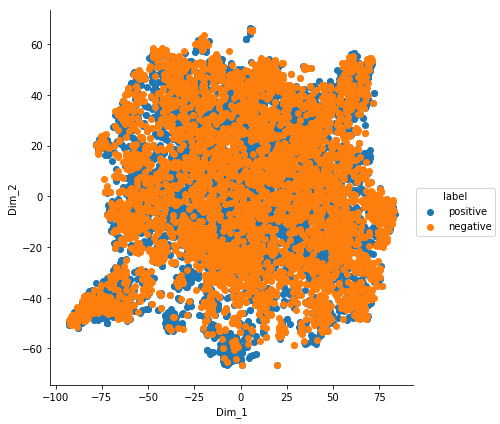

In [122]:
# PLotting the results 

sn.FacetGrid(tsne_df_tfidfweighted2, hue="label", size=6).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
plt.show()

In [ ]:
'''The above figure is a 'tsne' representation with perplexity as 40 and n_iter as 2000 by using 
'TfIdf weighted W2Vec' as vectorizer for the given reviews data.'''

# Creating a 'tsne' model using the AvgW2Vec representation of the text data by changing the perplexity(50) and number of iterations(2000)

In [124]:
model_tfidfweighted3 = TSNE(n_components=2, random_state=0, perplexity = 50, n_iter = 2000)
# configuring the parameteres
# the number of components = 2
# perplexity = 50
# default learning rate = 200
# Maximum number of iterations for the optimization = 2000

tsne_data_tfidfweighted3 = model_tfidfweighted3.fit_transform(data_tfidf)

In [125]:
# creating a new data frame which help us in ploting the result data
tsne_data_tfidfweighted3 = np.vstack((tsne_data_tfidfweighted3.T, reviews_final['Score'])).T
tsne_df_tfidfweighted3 = pd.DataFrame(data=tsne_data_tfidfweighted3, columns=("Dim_1", "Dim_2", "label"))


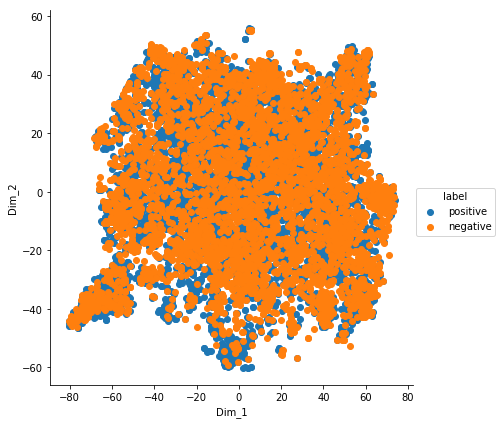

In [126]:
# PLotting the results 

sn.FacetGrid(tsne_df_tfidfweighted3, hue="label", size=6).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
plt.show()

In [ ]:
'''The above figure is a 'tsne' representation with perplexity as 50 and n_iter as 2000 by using 
'TfIdf weighted W2Vec' as vectorizer for the given reviews data.'''

# Note: We have represented the various word vectors using the tsne plots where blue points represent the positive reviews and orange points represent the negative reviews. Although, we have not been able to see a clear separability in the 2-d plots. The scenarios might change if we make a 3-d representation of the plot or by increasing the number of reviews under consideration significantly.